# Notebook and Plots for GLM Blog in Scikit-Learn Foundation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF

# import datasets
from plotnine.data import diamonds

# scikit-learn
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.linear_model import GammaRegressor, Ridge
from sklearn.metrics import mean_squared_error, mean_gamma_deviance
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler

## 1. Real Worl Data Is Not Normal

Text(0.5, 1.0, 'QQ Plot of diamonds price')

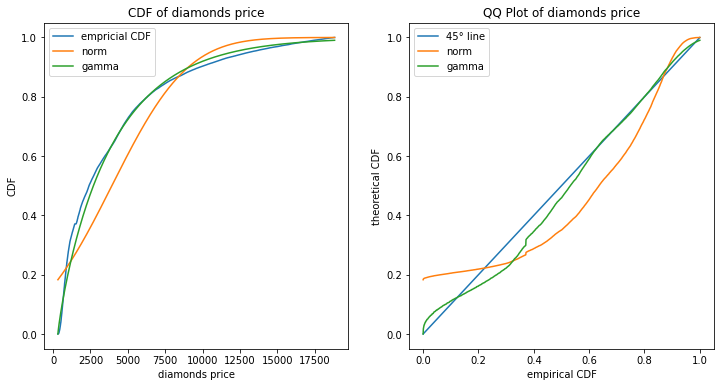

In [2]:
# https://stackoverflow.com/a/37616966 used as template
fig, axes = plt.subplots(1, 2, figsize=(6*2, 6))

y = np.sort(diamonds['price'])
ecdf = ECDF(y)
axes[0].plot(y, ecdf(y), label='empricial CDF')
axes[1].plot(ecdf(y), ecdf(y), label='45° line')

DISTRIBUTIONS = [stats.norm, stats.gamma]

for dist in DISTRIBUTIONS:
    params = dist.fit(y)
    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]
    
    # Plot CDF
    axes[0].plot(y, dist.cdf(y, loc=loc, scale=scale, *arg), label=dist.name)
    # QQ-Plot but with exchanged x- and y-axis such that x-axis stays stable
    axes[1].plot(ecdf(y), dist.cdf(y, loc=loc, scale=scale, *arg), label=dist.name)

axes[0].legend()
axes[0].set_xlabel('diamonds price')
axes[0].set_ylabel('CDF')
axes[0].set_title('CDF of diamonds price')

axes[1].legend()
axes[1].set_xlabel('empirical CDF')
axes[1].set_ylabel('theoretical CDF')
axes[1].set_title('QQ Plot of diamonds price')

## 2. OLS
Already advanced: Fit $log(y) = log(price)$ with feature $log(carat)$.

In [3]:
# Usually:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123)
# But using indices is simpler to keep df together

idx_train, idx_test = list(ShuffleSplit(n_splits=1, test_size=0.2, random_state=123)
                           .split(diamonds))[0]
idx_train.shape, idx_test.shape

df = diamonds.copy()
df['set'] = 'train'
df.loc[idx_test, 'set'] = 'test'

In [4]:
log_scale_transformer = make_pipeline(
    FunctionTransformer(np.log, validate=False),
    StandardScaler()
)

ols_preprocessor = ColumnTransformer(
    [("log_carat", log_scale_transformer,
            ["carat"]),
     ("onehot_categorical", OneHotEncoder(),
            ["cut", "color", "clarity"]),
    ]
)

In [5]:
ols =  Pipeline([
    ("preprocessor", ols_preprocessor),
    ("regressor",
     TransformedTargetRegressor(regressor=Ridge(alpha=1e-10),
                                func=np.log, inverse_func=np.exp)),
]).fit(df.loc[idx_train], df.loc[idx_train, 'price'])

In [6]:
dfp = df.copy()
dfp['observed'] = dfp['price']
dfp['predicted'] = ols.predict(df)

dfp = dfp.melt(id_vars=['carat', 'cut', 'color', 'clarity', 'set'], value_vars=['observed', 'predicted'])
dfp

,carat,cut,color,clarity,set,variable,value
0,0.23,Ideal,E,SI2,train,observed,326.000000
1,0.21,Premium,E,SI1,test,observed,326.000000
2,0.23,Good,E,VS1,train,observed,327.000000
3,0.29,Premium,I,VS2,train,observed,334.000000
4,0.31,Good,J,SI2,train,observed,335.000000
...,...,...,...,...,...,...,...
107875,0.72,Ideal,D,SI1,train,predicted,2954.924540
107876,0.72,Good,D,SI1,train,predicted,2738.641532
107877,0.70,Very Good,D,SI1,train,predicted,2682.189099
107878,0.86,Premium,H,SI2,test,predicted,2666.563641


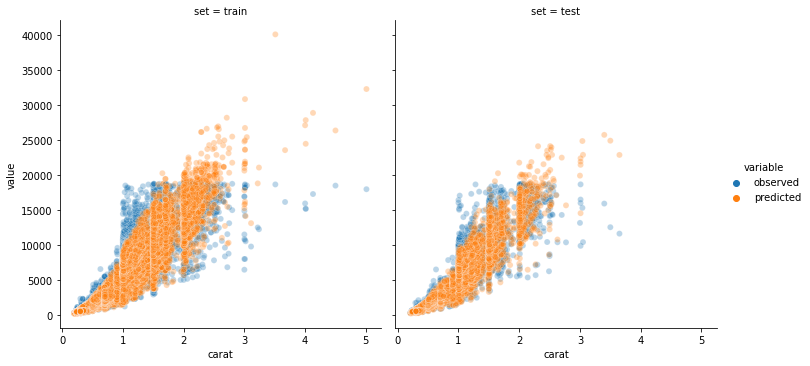

In [7]:
sns.relplot(data=dfp, x='carat', y='value', hue='variable', col='set', alpha=0.3)

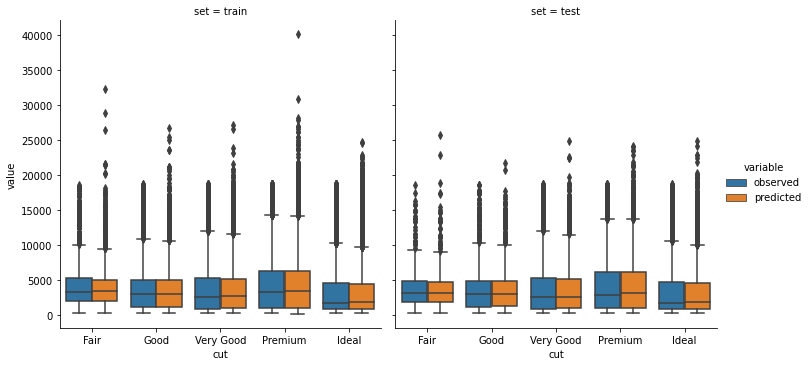

In [8]:
sns.catplot(data=dfp, x='cut', y='value', hue='variable', col='set', kind='box')

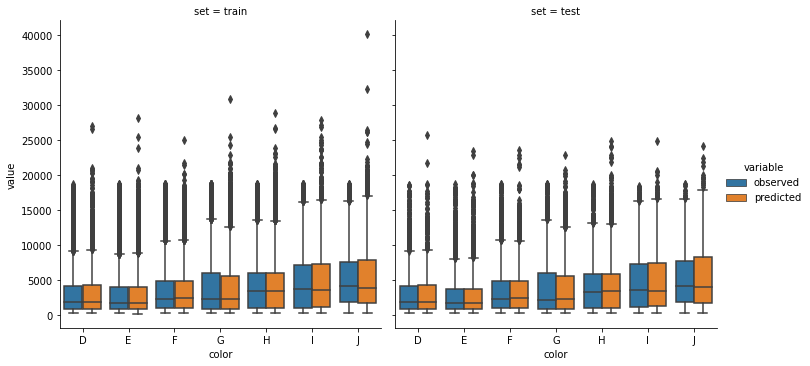

In [9]:
sns.catplot(data=dfp, x='color', y='value', hue='variable', col='set', kind='box')

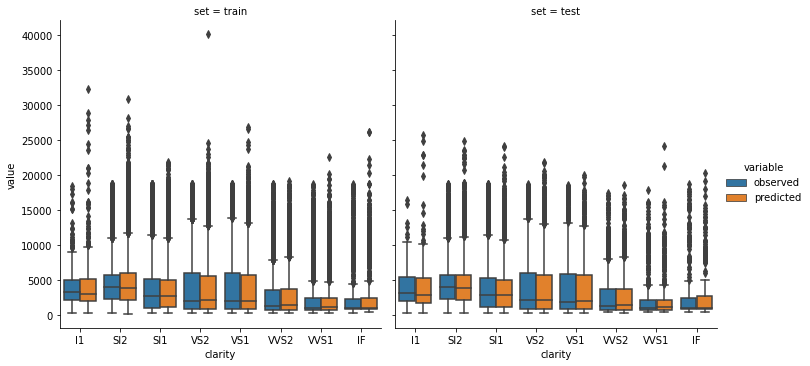

In [10]:
sns.catplot(data=dfp, x='clarity', y='value', hue='variable', col='set', kind='box')

## 3. GLM

In [11]:
glm =  Pipeline([
    ("preprocessor", ols_preprocessor),
    ("regressor",
     GammaRegressor(alpha=1e-10)),
]).fit(df.loc[idx_train], df.loc[idx_train, 'price'])

In [12]:
dfp = df.copy()
dfp['observed'] = dfp['price']
dfp['predicted'] = ols.predict(df)

dfp = dfp.melt(id_vars=['carat', 'cut', 'color', 'clarity', 'set'], value_vars=['observed', 'predicted'])

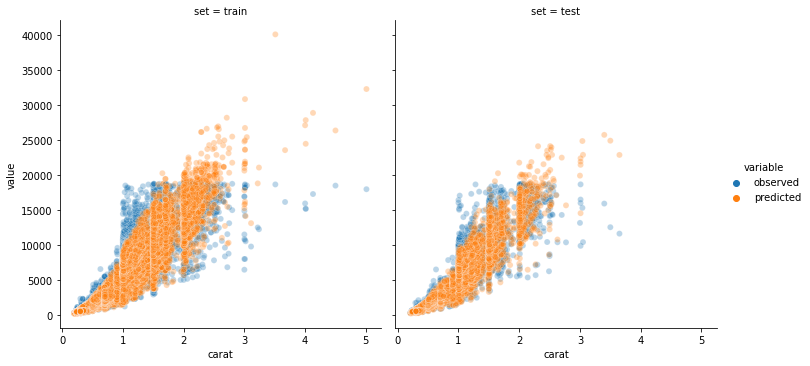

In [13]:
sns.relplot(data=dfp, x='carat', y='value', hue='variable', col='set', alpha=0.3)

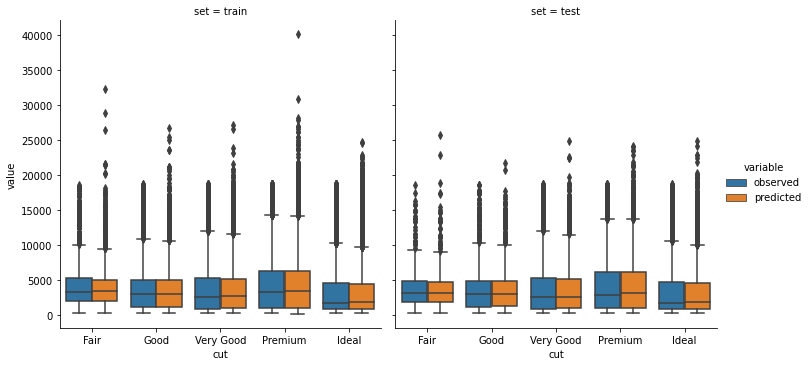

In [14]:
sns.catplot(data=dfp, x='cut', y='value', hue='variable', col='set', kind='box')

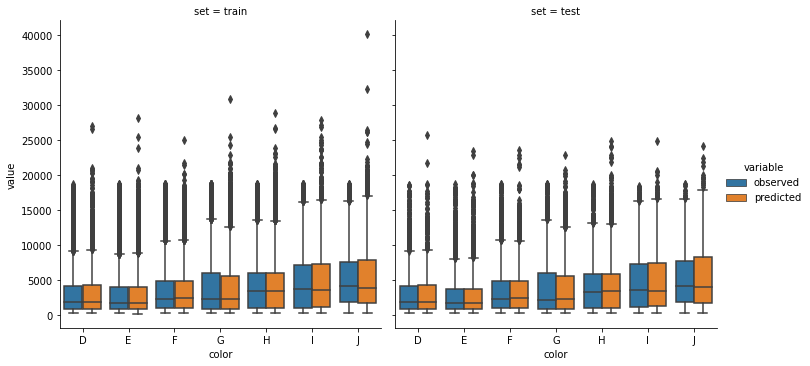

In [15]:
sns.catplot(data=dfp, x='color', y='value', hue='variable', col='set', kind='box')

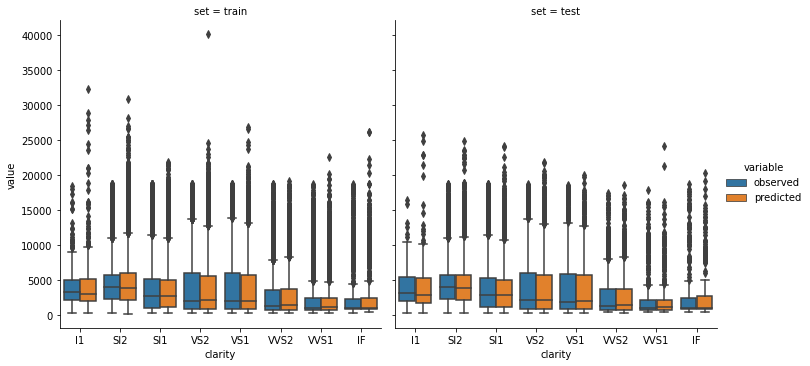

In [16]:
sns.catplot(data=dfp, x='clarity', y='value', hue='variable', col='set', kind='box')

## 4. Compare Models
### 4.1 RMSE

In [17]:
df['price'].mean()

3932.799721913237

In [18]:
print("OLS RMSE train = "
      f"{mean_squared_error(df.loc[idx_train, 'price'], ols.predict(df.loc[idx_train]), squared=False)}")
print("OLS RMSE test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], ols.predict(df.loc[idx_test]), squared=False)}")

OLS RMSE train = 795.0141246320875
OLS RMSE test = 822.7019148416877


In [19]:
print("GLM RMSE train = "
      f"{mean_squared_error(df.loc[idx_train, 'price'], glm.predict(df.loc[idx_train]), squared=False)}")
print("GLM RMSE test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], glm.predict(df.loc[idx_test]), squared=False)}")

GLM RMSE train = 796.6036855246268
GLM RMSE test = 826.3615185000725


### 4.2 Gamma Deviance

In [20]:
print("OLS Gamma Deviance train = "
      f"{mean_gamma_deviance(df.loc[idx_train, 'price'], ols.predict(df.loc[idx_train]))}")
print("OLS Gamma Deviance test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], ols.predict(df.loc[idx_test]))}")

OLS Gamma Deviance train = 0.018105574500543318
OLS Gamma Deviance test = 676838.4406841795


In [21]:
print("GLM Gamma Deviance train = "
      f"{mean_gamma_deviance(df.loc[idx_train, 'price'], glm.predict(df.loc[idx_train]))}")
print("GLM Gamma Deviance test = "
      f"{mean_squared_error(df.loc[idx_test, 'price'], glm.predict(df.loc[idx_test]))}")

GLM Gamma Deviance train = 0.018013063019539272
GLM Gamma Deviance test = 682873.3592577458


### 4.2 Balance Property / Bias
Ideally, on training set, one has $\sum predicted = \sum observed$. Both estimators do not fullfil this requirement. The ols becouse of the backtransformation from $\log(y)$ to $y$, the GLM because the $log$ link is not the canonical link.

In [28]:
print("OLS on training set: sum predicted - sum observed = ",
      ols.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum())
print("GLM on training set: sum predicted - sum observed = ",
      glm.predict(df.loc[idx_train]).sum() - df.loc[idx_train, 'price'].sum())

OLS on training set: sum predicted - sum observed =  -1913520.5001902878
GLM on training set: sum predicted - sum observed =  -557294.8332321048


In [29]:
print("OLS on test set: sum predicted - sum observed = ",
       ols.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum())
print("GLM on test set: sum predicted - sum observed = ",
       glm.predict(df.loc[idx_test]).sum() - df.loc[idx_test, 'price'].sum())

OLS on test set: sum predicted - sum observed =  -427657.6305310875
GLM on test set: sum predicted - sum observed =  -91899.81473426521
